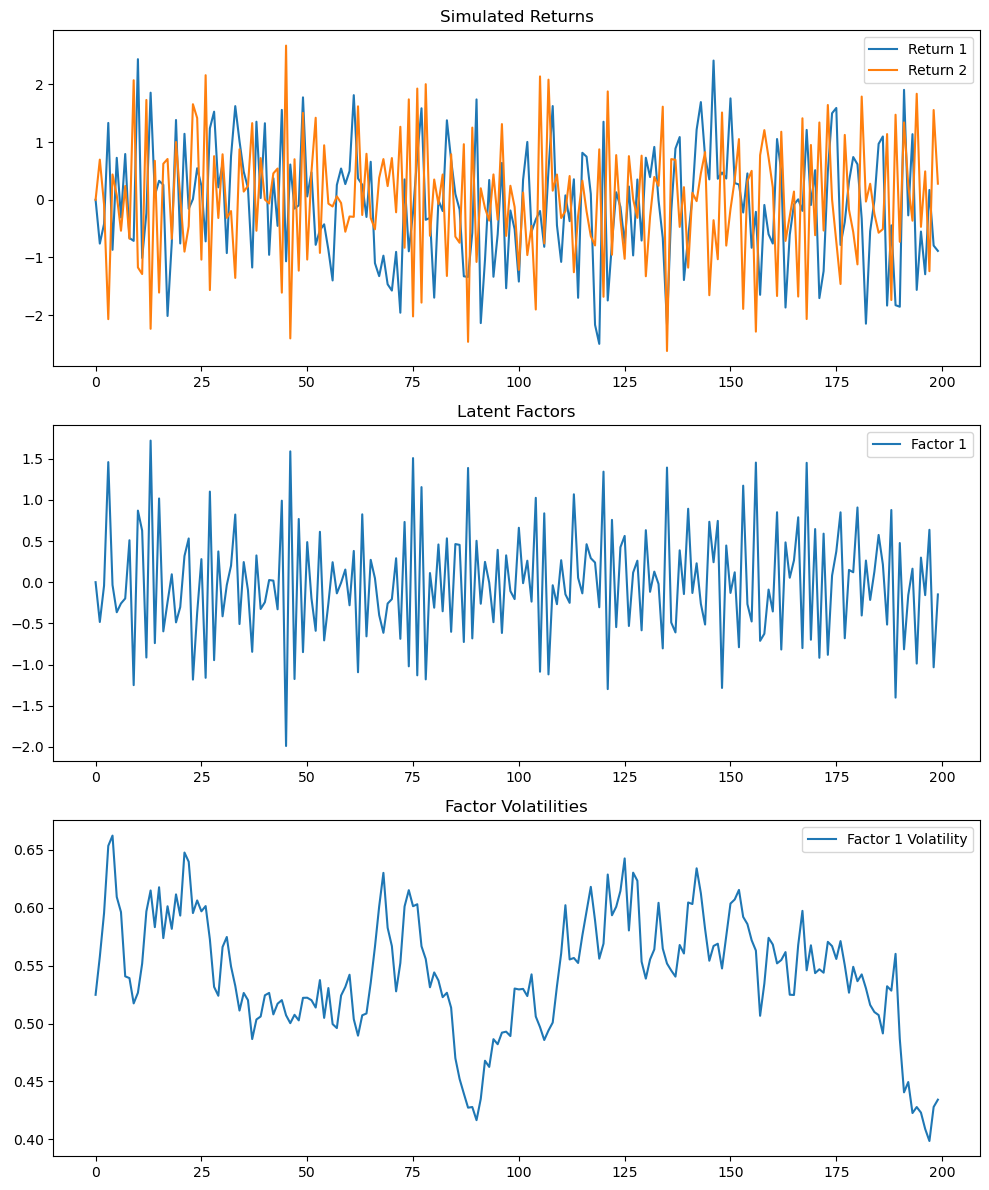

In [1]:
import numpy as np
from functions.simulation import DFSV_params, simulate_DFSV
from functions.filters import DFSVBellmanFilter
import matplotlib.pyplot as plt
# Set random seed for reproducibility
np.random.seed(123)

# Create test parameters

# Model dimensions
N, K = 2, 1
T = 200

# Create stationary factor transition matrix (eigenvalues < 1)
Phi_f_raw = np.random.normal(0, 0.5, size=(K, K))
Phi_f = 0.7 * Phi_f_raw / np.max(np.abs(np.linalg.eigvals(Phi_f_raw)))

# Create stationary volatility transition matrix (eigenvalues < 1)
Phi_h_raw = np.random.normal(0, 0.5, size=(K, K))
Phi_h = 0.9 * Phi_h_raw / np.max(np.abs(np.linalg.eigvals(Phi_h_raw)))

# Other parameters
lambda_r = np.random.normal(0, 1, size=(N, K))
mu = np.random.normal(-1, 0.5, size=(K, 1))
sigma2 = np.diag(np.exp(np.random.normal(-1, 0.5, size=N)))

# Create positive definite Q_h matrix
Q_h_raw = np.random.normal(0, 0.5, size=(K, K))
Q_h = 0.2 * (Q_h_raw @ Q_h_raw.T)

# Create model parameters
params = DFSV_params(
    N=N, 
    K=K, 
    lambda_r=lambda_r,
    Phi_f=Phi_f,
    Phi_h=Phi_h,
    mu=mu,
    sigma2=sigma2,
    Q_h=Q_h
)

# Create some artificial data
returns, factors, volatilities = simulate_DFSV(params, T=T)
#Plot the simulated data
# Create plot with subplots for returns, factors, and volatilities
fig, axes = plt.subplots(3, 1, figsize=(10, 12))

# Plot returns
for i in range(N):
    axes[0].plot(returns[:,i], label=f"Return {i+1}")
axes[0].set_title("Simulated Returns")
axes[0].legend()

# Plot 
for i in range(K):
    axes[1].plot(factors[:,i], label=f"Factor {i+1}")
axes[1].set_title("Latent Factors")
axes[1].legend()

# Plot volatilities (exp(h/2) for standard deviations)
for i in range(K):
    axes[2].plot(np.exp(volatilities[:,i]/2), label=f"Factor {i+1} Volatility")
axes[2].set_title("Factor Volatilities")
axes[2].legend()

plt.tight_layout()



In [20]:
# Initialize the filter
filter = DFSVBellmanFilter(params)
# Initialize the filter with the first observation
state,cov=filter.initialize_state(returns)
display(state,cov)

array([[ 0.        ],
       [ 0.        ],
       [-1.22199098],
       [-1.21717564]])

array([[1.        , 0.        , 0.        , 0.        ],
       [0.        , 1.        , 0.        , 0.        ],
       [0.        , 0.        , 0.35095176, 0.00647948],
       [0.        , 0.        , 0.00647948, 0.57081635]])

In [24]:

pred_state,pred_cov=filter.predict(state,cov)
display(pred_state,pred_cov)
# Update the filter with the first observation
# state, cov = filter.update(state, cov, returns[0,:])
alpha=np.array([1,0,0,1])
I_pred=np.linalg.pinv(pred_cov)
filter.bellman_gradient(alpha,predicted_state=pred_state, I_pred=I_pred, observation=returns[0,:])

array([[ 0.        ],
       [ 0.        ],
       [-1.22199098],
       [-1.21717564]])

array([[ 0.60004322, -0.25427958,  0.        ,  0.        ],
       [-0.25427958,  0.62615681,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.35095176,  0.00647948],
       [ 0.        ,  0.        ,  0.00647948,  0.57081635]])

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 3 is different from 2)